# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: America Movil SAB de CV L	(AMXL.MX), Walmart de Mexico SAB de CV	(WALMEX.MX) y Fomento Economico Mexicano S.A.B. de C.V.	(FEMSAUBD.MX).

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None, freq='m'):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.YahooDailyReader(symbols=tickers, start=start_date, end=end_date, interval=freq).read()['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Descargar precios y graficar
closes = get_adj_closes(tickers=['AMXL.MX', 'WALMEX.MX', 'FEMSAUBD.MX'],
                        start_date='2010-01-01')

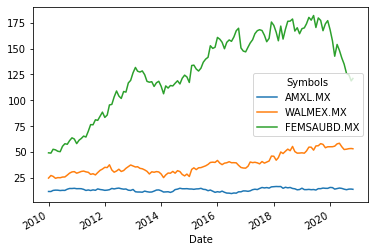

In [4]:
closes.plot();

1.2. A partir de los precios, obtener los rendimientos mensuales:

In [5]:
# Obtener rendimientos mensuales y graficar
ret = ((closes - closes.shift()) / closes.shift()).dropna()

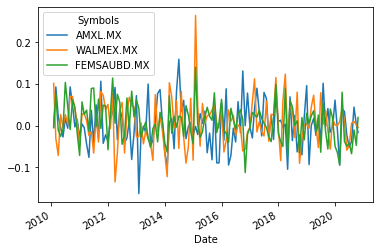

In [6]:
ret.plot();

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [7]:
# Resumen: rendimiento medio mensual y volatilidad
monthly_ret_summ = pd.DataFrame({'Media': ret.mean(),
                                 'Vol': ret.std()})
monthly_ret_summ

,Media,Vol
Symbols,,
AMXL.MX,0.002784,0.054955
WALMEX.MX,0.007423,0.055529
FEMSAUBD.MX,0.008022,0.046074


In [8]:
# Matriz de covarianza
cov = ret.cov()
cov

Symbols,AMXL.MX,WALMEX.MX,FEMSAUBD.MX
Symbols,,,
AMXL.MX,0.003020,0.000293,0.000411
WALMEX.MX,0.000293,0.003083,0.000926
FEMSAUBD.MX,0.000411,0.000926,0.002123


In [10]:
# Matriz de correlación
corr = ret.corr()
corr

Symbols,AMXL.MX,WALMEX.MX,FEMSAUBD.MX
Symbols,,,
AMXL.MX,1.000000,0.096018,0.162508
WALMEX.MX,0.096018,1.000000,0.361765
FEMSAUBD.MX,0.162508,0.361765,1.000000


___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [11]:
# Tasa libre de riesgo
rf = 0.0414 / 12

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [12]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_portafolios = 1000000
n_activos = len(monthly_ret_summ)

2.1. Generamos los portafolios

In [13]:
# Ayuda en la funcion numpy.random.dirichlet
help(np.random.dirichlet)

Help on built-in function dirichlet:

dirichlet(...) method of numpy.random.mtrand.RandomState instance
    dirichlet(alpha, size=None)
    
    Draw samples from the Dirichlet distribution.
    
    Draw `size` samples of dimension k from a Dirichlet distribution. A
    Dirichlet-distributed random variable can be seen as a multivariate
    generalization of a Beta distribution. The Dirichlet distribution
    is a conjugate prior of a multinomial distribution in Bayesian
    inference.
    
    .. note::
        New code should use the ``dirichlet`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    alpha : array
        Parameter of the distribution (k dimension for sample of
        dimension k).
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned

In [14]:
# Generar una matriz de pesos de n_portafolios x n_activos,
# tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet(alpha=np.ones(n_activos), size=n_portafolios)

In [15]:
W

array([[0.4186137 , 0.30179882, 0.27958748],
       [0.94772451, 0.00198836, 0.05028714],
       [0.1485287 , 0.70262069, 0.14885061],
       ...,
       [0.18603123, 0.7632777 , 0.05069106],
       [0.04606072, 0.61056059, 0.34337869],
       [0.17364541, 0.02087164, 0.80548295]])

In [16]:
W.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [17]:
W.shape

(1000000, 3)

In [20]:
# Rendimientos y volatilidad de cada portafolios
Eind = monthly_ret_summ.loc[:, 'Media'].values
E_portafolios = W.dot(Eind)

In [22]:
E_portafolios.shape

(1000000,)

In [24]:
s_portafolios = np.zeros(n_portafolios)
for i in range(n_portafolios):
    s_portafolios[i] = (W[i, :].T.dot(cov).dot(W[i, :]))**0.5

In [26]:
# Radio de Sharpe
RS = (E_portafolios - rf) / s_portafolios

In [27]:
# Data frame de resultados
resultados = pd.DataFrame(columns=['w1', 'w2', 'w3', 'Media', 'Vol', 'RS'], 
                          index=list(range(n_portafolios)))
resultados[['w1', 'w2', 'w3']] = W
resultados['Media'] = E_portafolios
resultados['Vol'] = s_portafolios
resultados['RS'] = RS
resultados.head()

,w1,w2,w3,Media,Vol,RS
0,0.418614,0.301799,0.279587,0.005648,0.036091,0.060906
1,0.947725,0.00198836,0.0502871,0.003056,0.052521,-0.007496
2,0.148529,0.702621,0.148851,0.006823,0.043690,0.077199
3,0.524559,0.136696,0.338745,0.005192,0.037499,0.046457
4,0.585317,0.0615625,0.35312,0.004919,0.039275,0.037399


2.2. Aproximar portafolio de mínima varianza y portafolio eficiente en media varianza

In [29]:
# Portafolio EMV
portafolio_EMV = resultados.loc[resultados['RS'].idxmax()]
portafolio_EMV

w1       4.59682e-07
w2          0.288118
w3          0.711882
Media       0.007849
Vol        0.0413694
RS          0.106334
Name: 354611, dtype: object

In [30]:
# Portafolio mínima varianza
portafolio_minvar = resultados.loc[resultados['Vol'].idxmin()]
portafolio_minvar

w1         0.333529
w2         0.249541
w3          0.41693
Media    0.00612512
Vol       0.0353946
RS        0.0755799
Name: 174827, dtype: object

2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

[0.034, 0.057, 0.002, 0.009]

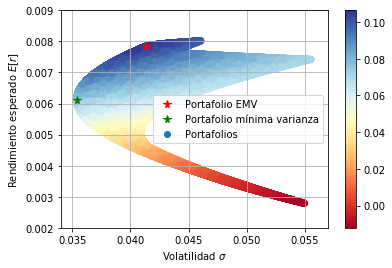

In [33]:
# Gráfica
plt.figure(figsize=(6, 4))
plt.scatter(resultados['Vol'], 
            resultados['Media'],
            c=resultados['RS'],
            cmap='RdYlBu',
            label='Portafolios')
# EMV
plt.plot(portafolio_EMV['Vol'], portafolio_EMV['Media'], '*r', ms=8, label='Portafolio EMV')
# Min var
plt.plot(portafolio_minvar['Vol'], portafolio_minvar['Media'], '*g', ms=8, label='Portafolio mínima varianza')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento esperado $E[r]$')
plt.grid()
plt.legend(loc='best')
plt.colorbar()
plt.axis([0.034, 0.057, 0.002, 0.009])

## 3. Comparar con los resultados obtenidos por optimización

3.1. Portafolio de mínima varianza

In [35]:
# Importamos funcion minimize del modulo optimize de scipy
from scipy.optimize import minimize

In [36]:
## Construcción de parámetros
# 1. Sigma: matriz de varianza-covarianza
Sigma = cov.values
# 2. Eind: rendimientos esperados activos individuales
Eind, Sigma

(array([0.00278367, 0.00742275, 0.00802151]),
 array([[0.00302007, 0.00029301, 0.00041147],
        [0.00029301, 0.00308348, 0.00092556],
        [0.00041147, 0.00092556, 0.00212281]]))

In [37]:
# Función objetivo
def var(w, Sigma):
    return w.T.dot(Sigma).dot(w)

In [38]:
# Dato inicial
w0 = np.ones(n_activos) / n_activos
# Cotas de las variables
bnds = ((0, 1), ) * n_activos
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

In [41]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [43]:
# Portafolio Min var
minvar = minimize(fun=var,
                  x0=w0,
                  args=(Sigma, ),
                  bounds=bnds,
                  constraints=cons,
                  tol=1e-8)
minvar

     fun: 0.0012527805865628675
     jac: array([0.00250556, 0.00250556, 0.00250556])
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.33384381, 0.2494974 , 0.41665879])

In [40]:
# Comparar
portafolio_minvar

w1         0.333529
w2         0.249541
w3          0.41693
Media    0.00612512
Vol       0.0353946
RS        0.0755799
Name: 174827, dtype: object

3.2. Portafolio EMV

In [46]:
# Función objetivo
def menos_RS(w, rf, Eind, Sigma):
    s_p = (w.T.dot(Sigma).dot(w))**0.5
    E_p = w.T.dot(Eind)
    RS = (E_p - rf) / s_p
    return -RS

In [47]:
# Dato inicial
w0 = np.ones(n_activos) / n_activos
# Cotas de las variables
bnds = ((0, 1), ) * n_activos
# Restricciones
cons = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

In [48]:
# Portafolio EMV
emv = minimize(fun=menos_RS,
               x0=w0,
               args=(rf, Eind, Sigma),
               bounds=bnds,
               constraints=cons,
               tol=1e-8)
emv

     fun: -0.1063344937265032
     jac: array([-0.04383593, -0.08338777, -0.08338625])
 message: 'Optimization terminated successfully.'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.        , 0.28739446, 0.71260554])

In [49]:
# Comparar
portafolio_EMV

w1       4.59682e-07
w2          0.288118
w3          0.711882
Media       0.007849
Vol        0.0413694
RS          0.106334
Name: 354611, dtype: object

# Conclusión

- Tenemos una herramienta para aproximar toda la teoría de Markowitz.

- Esta herramienta no involucra optimización, solo generar números aleatorios normalizados.

- Por tanto, no le afecta el problema de dimensión (cuando tenemos muchos activos).

# Anuncios parroquiales

## 1. Fin de módulo. Abrir Clase0 y revisar objetivos del módulo.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>